In [1]:
import os
import pandas as pd
import pyreadr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
plt.rcParams['figure.figsize'] = [12, 8]

In [25]:
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
os.chdir("/rds/general/project/hda-22-23/live/TDS/ek2018") # set wd
data = pyreadr.read_r('../ek2018/ML/final_data2.rds') # import data
print(data.keys())
data = data[None]

# one hot encoding
one_hot_encoded_cols = pd.get_dummies(data[['smoking_status', 'alcohol_drinker_status', "employment_status", "qualifications", "chronotype"]])

# concatenate the one-hot encoded columns with the remaining columns in the original DataFrame
data_encoded = pd.concat([data.drop(['smoking_status', 'alcohol_drinker_status', "employment_status", "qualifications", "chronotype"], axis=1), one_hot_encoded_cols], axis=1)

odict_keys([None])


In [4]:
# convert some cols to integers
ordinal_cols = ['number_medications', 'days_walking', "days_moderate_activity", "days_vigorous_activity", "time_tv","time_phone", "sleep_duration", "alcohol_frequency",
               "ethnicity", "time_outdoors_summer", "time_outdoors_winter", "time_computer", "avg_household_income", "urban_rural", "maternal_smoking_at_birth", "mother_illness",
               "father_illness"]
# convert columns to integers
for col in ordinal_cols:
    data_encoded[col] = data_encoded[col].astype(int)
    
# move the outcome to be the last column and make it an integer
last_column = data_encoded.pop('incident_case')  # remove column 'A' and store it in a variable
data_encoded['incident_case'] = last_column

data_encoded['incident_case'] = data_encoded['incident_case'].astype(int)

In [5]:
# train and test split

X = data_encoded.drop(columns=['incident_case'])
Y = data_encoded['incident_case']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Clustering: DBScan

In [ ]:
plt.scatter(X_[:, 0], X_[:, 1])
plt.title("Random Sample of Blobs")

In [ ]:
from sklearn.decomposition import PCA


In [7]:
np.random.seed(234)
# randomly sample 20,000 controls for computation
# Select controls
controls = data_encoded[data_encoded['incident_case'] == 0]

# Sample 20,000 controls
sampled_controls = controls.sample(n=20000, random_state=42)

# Combine controls and cases
sampled_data = pd.concat([sampled_controls, data_encoded[data_encoded['incident_case'] == 1]])

# Shuffle the rows randomly
sampled_data = sampled_data.sample(frac=1, random_state=42)

In [8]:
print(sampled_data.shape)

# remove outcome label
clusterdata = sampled_data.drop(columns=['incident_case'])

(26991, 49)


In [80]:
# standardise data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clusterdata = scaler.fit_transform(clusterdata)

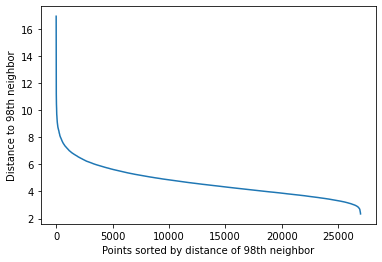

In [36]:
# tune epsilon 
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=98).fit(clusterdata)
distances, indices = nbrs.kneighbors(clusterdata)
distanceDec = sorted(distances[:,9], reverse=True)
plt.plot(range(1,len(clusterdata)+1), distanceDec)
plt.xlabel('Points sorted by distance of 98th neighbor')
plt.ylabel('Distance to 98th neighbor')
plt.show()

The optimal epsilon value is 222


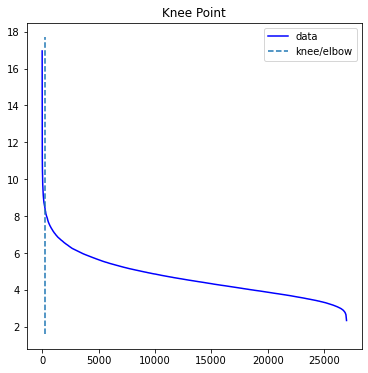

In [37]:
from kneed import KneeLocator
# compute sorted distances to the 10th nearest neighbor
nbrs = NearestNeighbors(n_neighbors=98).fit(clusterdata)
distances, indices = nbrs.kneighbors(clusterdata)
distanceDec = sorted(distances[:,9], reverse=True)

# create instance of KneeLocator
kneedle = KneeLocator(range(1,len(clusterdata)+1), distanceDec, curve='convex', direction='decreasing')

# retrieve the optimal epsilon value
optimal_epsilon = kneedle.knee

# print the optimal epsilon value
print(f"The optimal epsilon value is {optimal_epsilon}")

kneedle.plot_knee()
plt.show()

In [38]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(clusterdata)
    silhouette_avg = silhouette_score(clusterdata, cluster_labels)
    print("For n_clusters =", n_clusters,
         "the average silhouette score is", silhouette_avg)
    sample_silhouette_values = silhouette_samples(clusterdata, cluster_labels)

/rds/general/user/ek2018/home/anaconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 the average silhouette score is 0.06944065105415015


/rds/general/user/ek2018/home/anaconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 the average silhouette score is 0.0696504673546091


/rds/general/user/ek2018/home/anaconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 the average silhouette score is 0.05410651503611326


In [91]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=8, min_samples=98, metric = 'manhattan')
db.fit(clusterdata)
#labels = db.labels_
#fig = plt.figure(figsize=(10, 10))
#sns.scatterplot(clusterdata[:,0], clusterdata[:,1], hue=["cluster-{}".format(x) for x in labels])

DBSCAN(eps=222, metric='manhattan', min_samples=98)

In [92]:
set(db.labels_) # -1 means noisy points

{0}

In [88]:
# cluster size
from collections import Counter
Counter(db.labels_)

Counter({0: 26252, 1: 344, -1: 395})

In [48]:
p = sns.scatterplot(data = clusterdata, x = "t-SNE-1", y = "t-SNE-2", hue = db.labels_, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
plt.show()

/rds/general/user/ek2018/home/anaconda3/envs/mlenv/lib/python3.11/site-packages/seaborn/_oldcore.py:917: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


ValueError: Could not interpret value `t-SNE-1` for parameter `x`

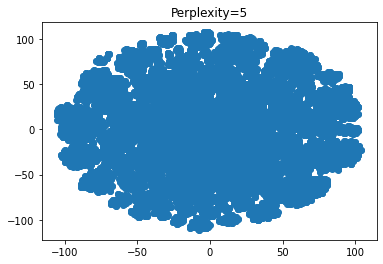

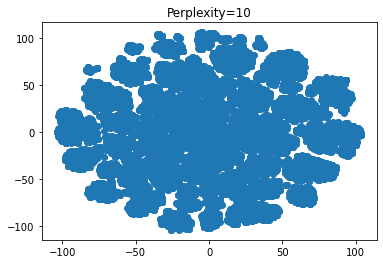

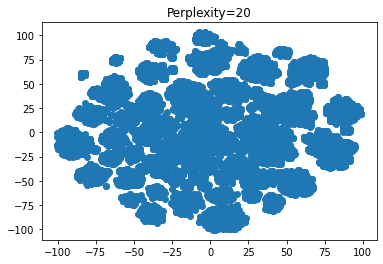

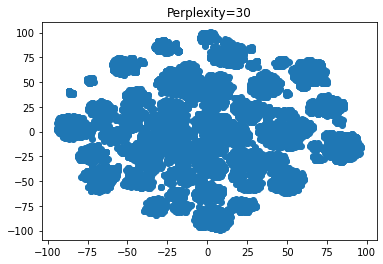

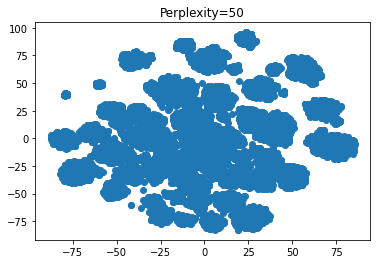

In [40]:
# for tSNE you need to tune perplexity
from sklearn.manifold import TSNE

perplexities = [5, 10, 20, 30, 50]
for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(clusterdata)
    plt.scatter(X_tsne[:,0], X_tsne[:,1])
    plt.title(f"Perplexity={perplexity}")
    plt.show()

In [82]:
from sklearn.manifold import TSNE
# Convert DataFrame to numpy array
tsne_data = np.array(clusterdata)

# Apply t-SNE to reduce the dimensionality of the data
tsne = TSNE(n_components=2, perplexity=100, random_state=0, learning_rate = 368)
X_tsne = tsne.fit_transform(tsne_data)


# Define a colormap with 10 discrete colors (to handle arbitrary number of clusters)
#n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
#cmap = ListedColormap(['blue', 'green', 'red', 'cyan'][:n_clusters])

# Plot the t-SNE embedding with discrete colors based on the DBSCAN cluster membership
#plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan.labels_, cmap=cmap)
#plt.colorbar()

#plt.show()

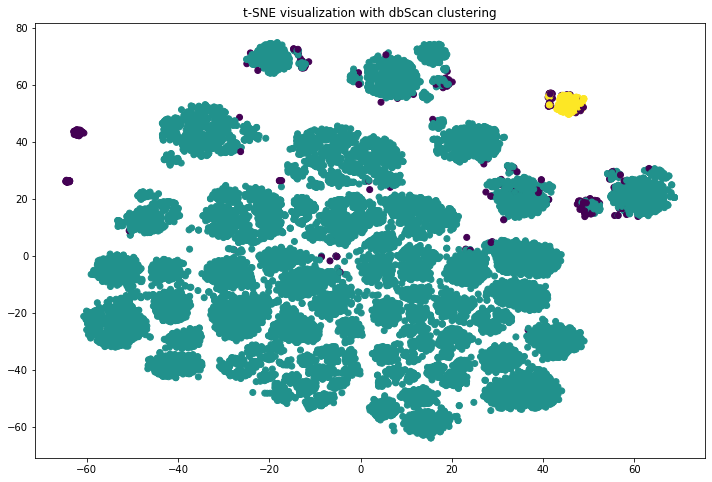

In [86]:
# Plot the transformed data with different colors for each cluster
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=db.labels_)
plt.title(f"t-SNE visualization with dbScan clustering")
plt.show()

# Clustering: KMeans

In [67]:
from sklearn.decomposition import PCA
pca = PCA().fit(clusterdata)

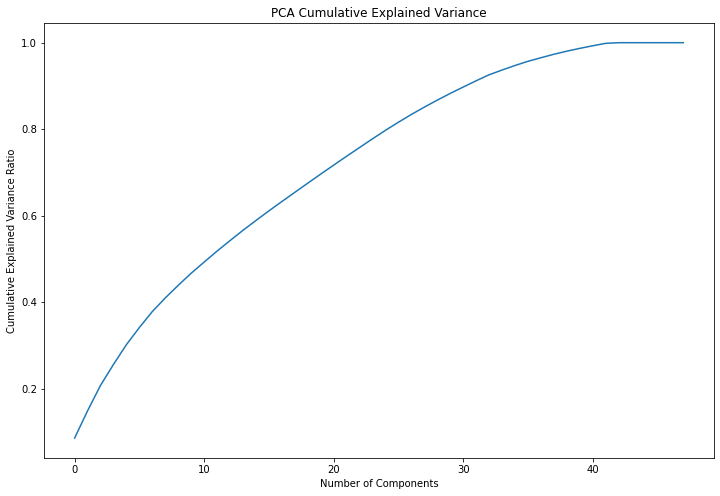

Number of components at elbow point: 43


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# create PCA object
pca = PCA()

# fit PCA on data
pca.fit(clusterdata)

# get explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_

# plot cumulative explained variance
cumulative_var_ratio = np.cumsum(explained_var_ratio)
plt.plot(cumulative_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance')
plt.show()

# find elbow point
diffs = np.diff(cumulative_var_ratio)
elbow = np.argmin(diffs) + 1

# use elbow point as number of components
print(f'Number of components at elbow point: {elbow}')


In [83]:
pca = PCA(n_components=43)
dementiaPCA = pca.fit_transform(clusterdata)

In [84]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
dementiaPCA_labels = kmeans.fit_predict(dementiaPCA)

/rds/general/user/ek2018/home/anaconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [85]:
dfdementiaPCA = pd.DataFrame(dementiaPCA)
dfdementiaPCA['cluster'] = dementiaPCA_labels

In [86]:
from sklearn.manifold import TSNE
X = dfdementiaPCA.iloc[:,:-1]
Xtsne = TSNE(n_components=2, perplexity=30).fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = dementiaPCA_labels
dftsne.columns = ['x1','x2','cluster']

<Axes: xlabel='x1', ylabel='x2'>

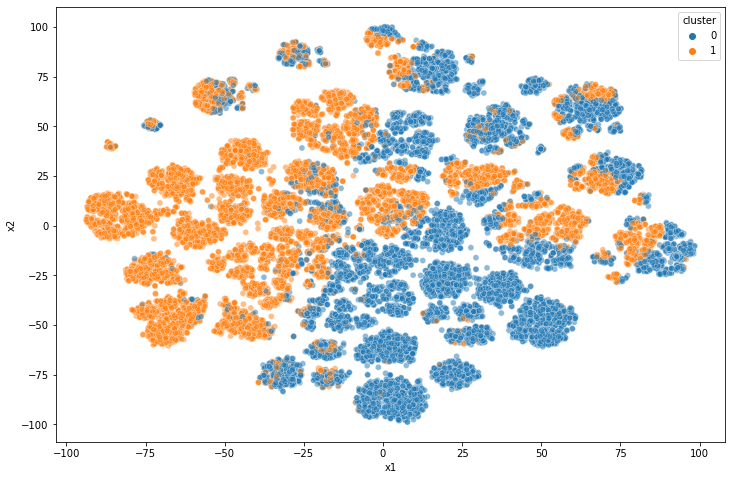

In [88]:
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5)

In [ ]:
from sklearn.manifold import TSNE
X = dfdementiaPCA.iloc[:,:-1]
Xtsne = TSNE(n_components=2).fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = dementiaPCA_labels
dftsne.columns = ['x1','x2','cluster']

In [107]:
clusterdata['cluster'] = dementiaPCA_labels

In [108]:
clusterdata = pd.DataFrame(clusterdata) # have to do this for the code below to run

In [111]:
# Some functions to plot just the variables that has significant deviation from global mean
def outside_limit(df, label_col, label, sensitivity):
  feature_list = clusterdata.columns[:-1]
  
  plot_list = []
  mean_overall_list = []
  mean_cluster_list = []
  
  for i,varname in enumerate(feature_list):
    
    #     get overall mean for a variable, set lower and upper limit
    mean_overall = df[varname].mean()
    lower_limit = mean_overall - (mean_overall*sensitivity)
    upper_limit = mean_overall + (mean_overall*sensitivity)

    #     get cluster mean for a variable
    cluster_filter = df[label_col]==label
    pd_cluster = df[cluster_filter]
    mean_cluster = pd_cluster[varname].mean()
    
    #     create filter to display graph with 0.5 deviation from the mean
    if mean_cluster <= lower_limit or mean_cluster >= upper_limit:
      plot_list.append(varname)
      mean_overall_std = mean_overall/mean_overall
      mean_cluster_std = mean_cluster/mean_overall
      mean_overall_list.append(mean_overall_std)
      mean_cluster_list.append(mean_cluster_std)
   
  mean_df = pd.DataFrame({'feature_list':plot_list,
                         'mean_overall_list':mean_overall_list,
                         'mean_cluster_list':mean_cluster_list})
  mean_df = mean_df.sort_values(by=['mean_cluster_list'], ascending=False)
  
  return mean_df

def plot_barchart_all_unique_features(df, label_col, label, ax, sensitivity):
  
  mean_df = outside_limit(df, label_col, label, sensitivity)
  mean_df_to_plot = mean_df.drop(['mean_overall_list'], axis=1)
  
  if len(mean_df.index) != 0:
    sns.barplot(y='feature_list', x='mean_cluster_list', data=mean_df_to_plot, palette=sns.cubehelix_palette(20, start=.5, rot=-.75, reverse=True), \
                alpha=0.75, dodge=True, ax=ax)

    for i,p in enumerate(ax.patches):
      ax.annotate("{:.02f}".format((p.get_width())), 
                  (1, p.get_y() + p.get_height() / 2.), xycoords=('axes fraction', 'data'),
                  ha='right', va='top', fontsize=10, color='black', rotation=0, 
                  xytext=(0, 0),
                  textcoords='offset pixels')
  
  ax.set_title('Unique Characteristics of Cluster ' + str(label))
  ax.set_xlabel('Standardized Mean')
  ax.axvline(x=1, color='k')

def plot_features_all_cluster(df, label_col, n_clusters, sensitivity):
  n_plot = n_clusters
  fig, ax = plt.subplots(n_plot, 1, figsize=(12, n_plot*6), sharex='col')
  ax= ax.ravel()
  
  label = np.arange(n_clusters)
  for i in label:
    plot_barchart_all_unique_features(df, label_col, label=i, ax=ax[i], sensitivity=sensitivity)
    ax[i].xaxis.set_tick_params(labelbottom=True, rotation=45)
    
  plt.tight_layout()
  display(fig)

/var/tmp/pbs.7506113.pbs/ipykernel_1960806/1523736943.py:18: FutureWarning:

reindexing with a non-unique Index is deprecated and will raise in a future version.



ValueError: cannot reindex on an axis with duplicate labels

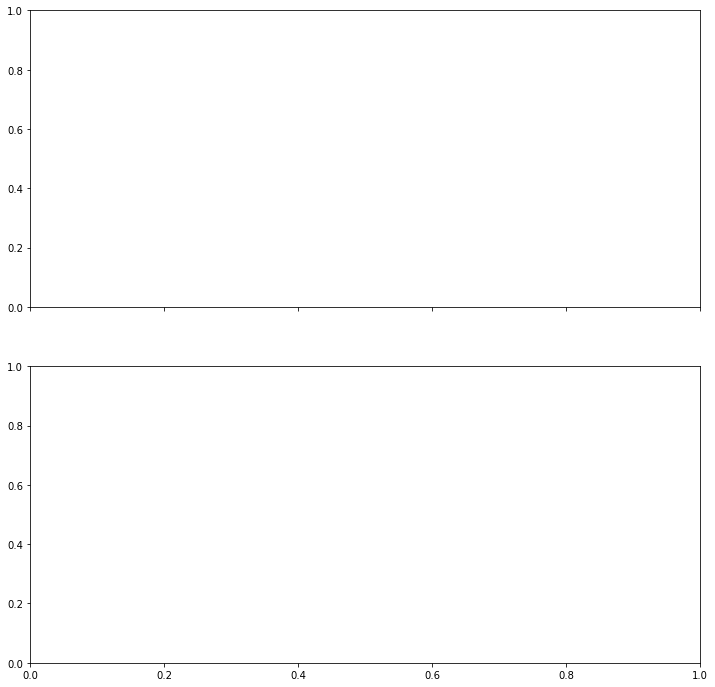

In [114]:
plot_features_all_cluster(df=clusterdata, label_col='cluster', n_clusters=2, sensitivity=0.2)

In [120]:
# Get the centroid values for each cluster
centroids = pca.inverse_transform(kmeans.cluster_centers_)

# Convert centroid values back into original feature space
cluster_features = pd.DataFrame(
    data=centroids,
    columns=clusterdata.columns[:-1]
)

# Print the feature values for each cluster
for i, row in cluster_features.iterrows():
    print(f"Cluster {i}:")
    print(row.sort_values(ascending=False)[:5])
    print()

    

Cluster 0:
34: 0.8059
1: 0.6575
3: 0.3465
7: 0.3322
24: 0.2740

Cluster 1:
33: 0.8660
17: 0.5743
8: 0.2814
40: 0.2539
27: 0.1385



/var/tmp/pbs.7506113.pbs/ipykernel_1960806/4254139120.py:23: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [121]:
clusterdata.head

<bound method NDFrame.head of               0         1         2         3         4         5         6  \
0      1.043981  1.045216 -0.280267  1.028823  0.798002 -1.142957 -0.863911   
1     -0.957872  0.188789  1.628986 -0.963617  0.798002 -0.725795 -0.863911   
2      1.043981 -1.034677  0.113622 -0.963617 -1.241567 -1.560119 -0.863911   
3      1.043981 -1.646410 -0.623603 -0.963617  0.798002 -0.725795  0.641468   
4     -0.957872  1.167562 -1.152909  1.360897  0.798002  0.108529  1.143262   
...         ...       ...       ...       ...       ...       ...       ...   
26986 -0.957872  0.066443  0.686208 -0.963617  0.288110 -0.308633  0.139675   
26987  1.043981 -1.768756 -0.317188 -0.299470  0.798002  1.360015  2.648641   
26988 -0.957872 -2.258143 -0.098736 -0.963617 -0.221783 -0.725795  0.139675   
26989 -0.957872 -0.667637 -0.485538  3.685411 -1.241567  0.525691  0.641468   
26990  1.043981  0.066443  1.298338  0.032603  0.798002  0.525691  0.139675   

              7      

# Random forest

In [12]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

In [59]:
# Define the pipeline
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.4)),
    ('under', RandomUnderSampler(sampling_strategy=0.6)),
    ('rf', RandomForestClassifier())
])


# Define the parameter grid for grid search
#param_grid = {
 #   'rf__n_estimators': [50, 100, 200],
  #  'rf__max_depth': [2, 5, 10, 15]}

param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [2, 5, 8],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Define the scoring metric for the grid search
scoring = {'accuracy': 'accuracy', 'recall':'recall', 'F1':'f1'}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring,n_jobs=4, cv=5, return_train_score=True,refit='accuracy')


In [60]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over', SMOTE(sampling_strategy=0.4)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.6)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'rf__max_depth': [2, 5, 8],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [10, 50, 100]},
             refit='accuracy', return_train_score=True,
             scoring={'F1': 'f1', 'accuracy': 'accuracy', 'recall': 'recall'})

In [61]:
# Check the dimensions of the dataset before and after sampling
print(f"Original dataset shape: {X_train.shape}")
X_train_resampled, y_train_resampled = pipeline['over'].fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = pipeline['under'].fit_resample(X_train_resampled, y_train_resampled)
print('Resampled data shape:', X_train_resampled.shape)

Original dataset shape: (21592, 48)
Resampled data shape: (17069, 48)


In [62]:
# save the data so i can use it in R
X_train_resampled.to_csv('X_train_resampled.csv', index=False)
y_train_resampled.to_csv('y_train_resampled.csv', index=False)

In [63]:
print('\nBalance of positive and negative classes (%):')
y_train_resampled.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


0    62.499268
1    37.500732
Name: incident_case, dtype: float64

In [64]:
# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_
print(best_estimator)

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.4)),
                ('under', RandomUnderSampler(sampling_strategy=0.6)),
                ('rf',
                 RandomForestClassifier(max_depth=2, min_samples_split=10))])


In [65]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}


In [66]:
# Predict on the test data using the best estimator
y_pred = best_estimator.predict(X_test)

In [67]:
# Calculate the accuracy score on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Accuracy on the test set
from sklearn.metrics import accuracy_score
print("\033[1m Accuracy of Random forest on test set:","{:.2%}".format(accuracy_score(y_test, y_pred)))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7721800333395074
 Accuracy of Random forest on test set: 77.22%
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      3997
           1       0.56      0.55      0.56      1402

    accuracy                           0.77      5399
   macro avg       0.70      0.70      0.70      5399
weighted avg       0.77      0.77      0.77      5399



In [68]:
# we should use average accuracy not true accuracy
# Access the cv_results_ dictionary
cv_results = grid_search.cv_results_

# Get the mean test accuracy for each parameter combination
mean_test_accuracy = cv_results['mean_test_accuracy']

# Find the index of the best parameter combination
best_index = np.argmax(mean_test_accuracy)

# Get the best mean test accuracy
best_accuracy = mean_test_accuracy[best_index]

# Print the best accuracy
print("Best accuracy:", best_accuracy)

Best accuracy: 0.7707017185822503


In [69]:
# balanced accuracy?
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.7002646778236317

In [70]:
# Calculate accuracy on the training data
y_train_pred = best_estimator.predict(X_train_resampled)
accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
print("Train Accuracy:", accuracy_train)

print(classification_report(y_train_resampled, y_train_pred))


Train Accuracy: 0.731853066963501
              precision    recall  f1-score   support

           0       0.75      0.85      0.80     10668
           1       0.69      0.53      0.60      6401

    accuracy                           0.73     17069
   macro avg       0.72      0.69      0.70     17069
weighted avg       0.73      0.73      0.72     17069



In [71]:
# Calculate the AUC score on the test data
y_prob = best_estimator.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

AUC: 0.8087145066360399


In [52]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
# Print the classification matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix, test:")
print(cm)

# Print the classification matrix
cm_train = confusion_matrix(y_train_resampled, y_train_pred)
print("Confusion Matrix, train:")
print(cm_train)

Confusion Matrix, test:
[[3418  579]
 [ 634  768]]
Confusion Matrix, train:
[[9073 1595]
 [3086 3315]]


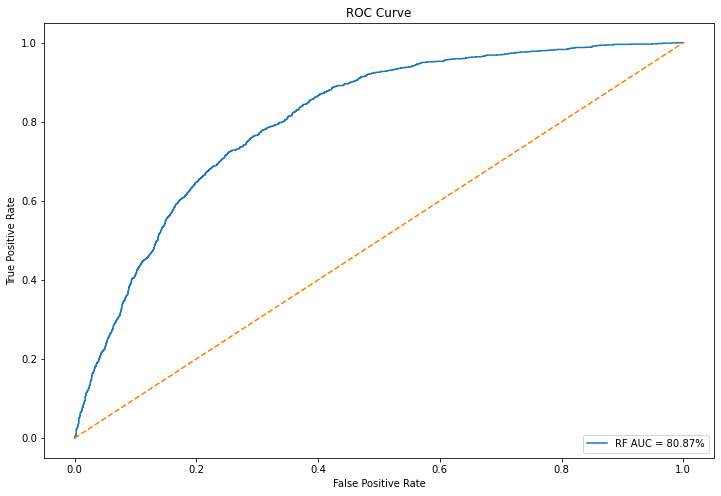

In [72]:
# roc curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr_rf, tpr_rf, label='RF AUC = {:.2f}%'.format(auc*100))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.show()

In [73]:
print(tpr_rf)
print(fpr_rf)

[0.00000000e+00 7.13266762e-04 2.13980029e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.         0.         0.         ... 0.99874906 0.99974981 1.        ]


Confusion Matrix:
 [[3418  579]
 [ 634  768]]


Text(87.0, 0.5, 'True')

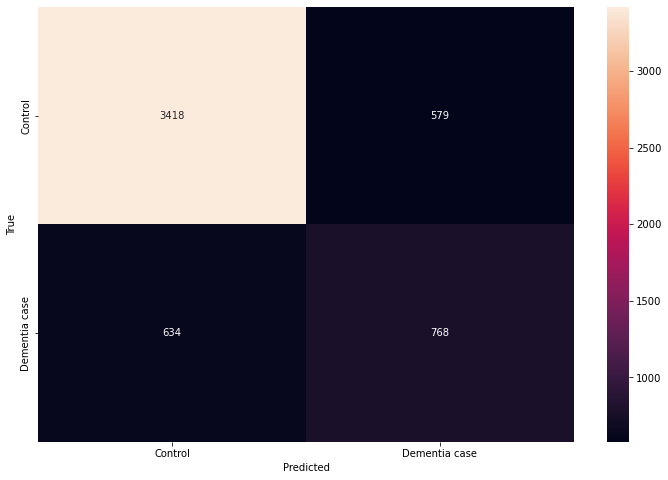

In [54]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt='g',
                       xticklabels=['Control', 'Dementia case'],
            yticklabels=['Control', 'Dementia case'])
plt.xlabel('Predicted')
plt.ylabel('True')

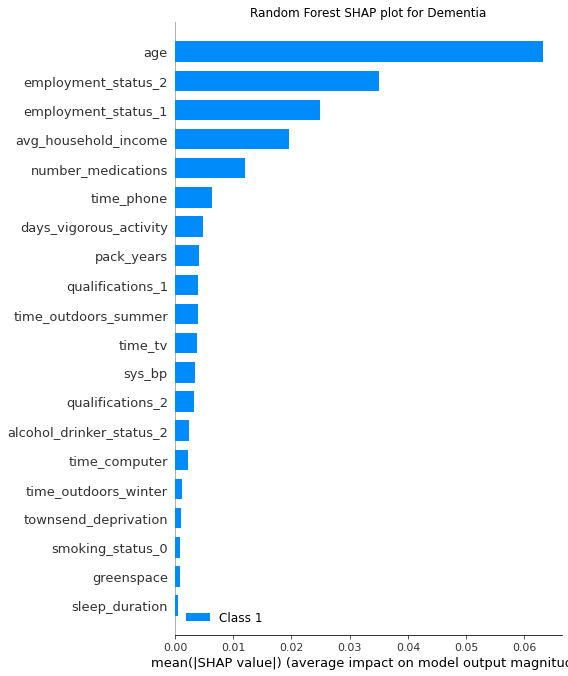

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


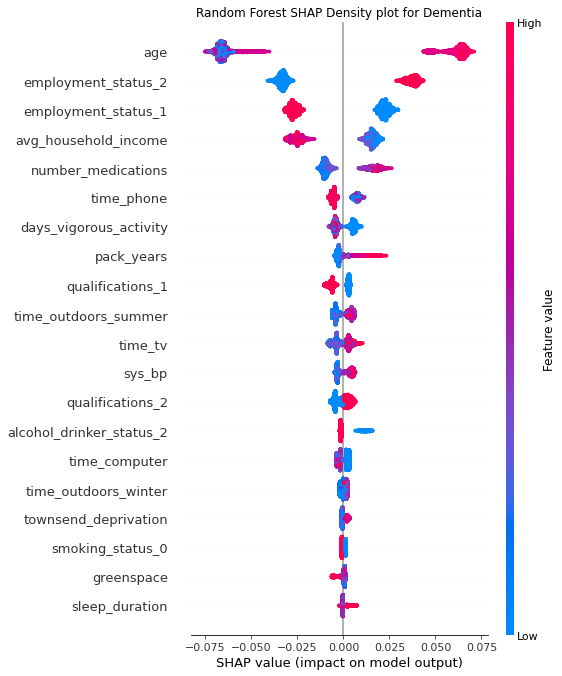

In [55]:
import shap
explainer = shap.TreeExplainer(best_estimator.named_steps['rf'])
shap_values = explainer.shap_values(X_test)

plt.title('Random Forest SHAP plot for Dementia')
shap.summary_plot(shap_values, features = X_test, class_inds = [1])
plt.show()

plt.title('Random Forest SHAP Density plot for Dementia')
shap.summary_plot(shap_values[1], features = X_test)
plt.show()

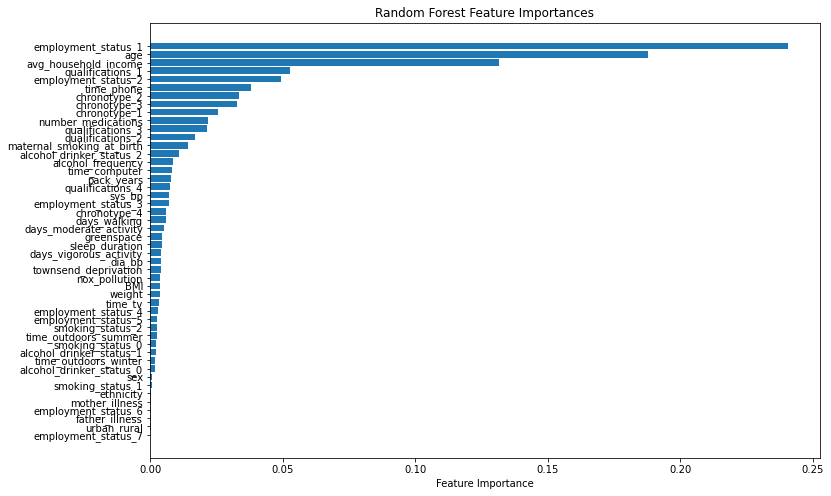

In [44]:
# Get the trained random forest classifier from the pipeline
rf = grid_search.best_estimator_.named_steps['rf']
# Get the feature importances
importances = rf.feature_importances_
indices = importances.argsort()
features = X_train_resampled.columns[indices]

# plot the feature importances as a horizontal bar chart
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

In [ ]:
# shap plot
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

plt.title('Random Forest SHAP plot for Dementia')
shap.summary_plot(shap_values, features = X_test, class_inds = [1])
plt.show()

plt.title('Random Forest SHAP Density plot for Dementia')
shap.summary_plot(shap_values[1], features = X_test)
plt.show()

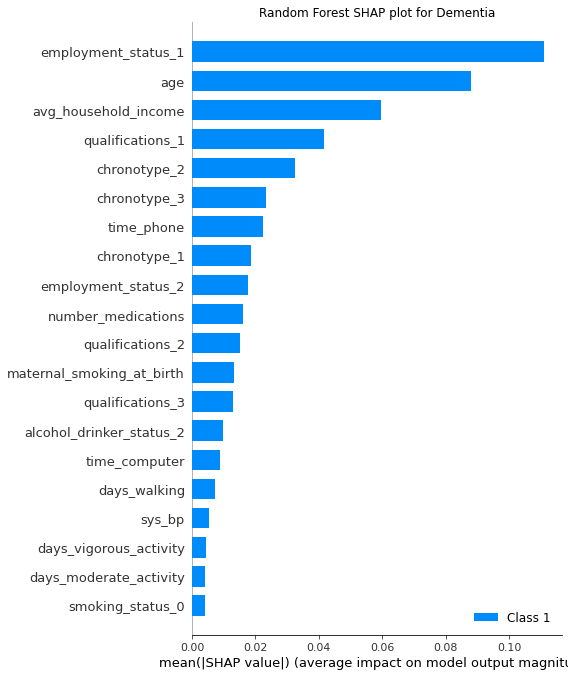

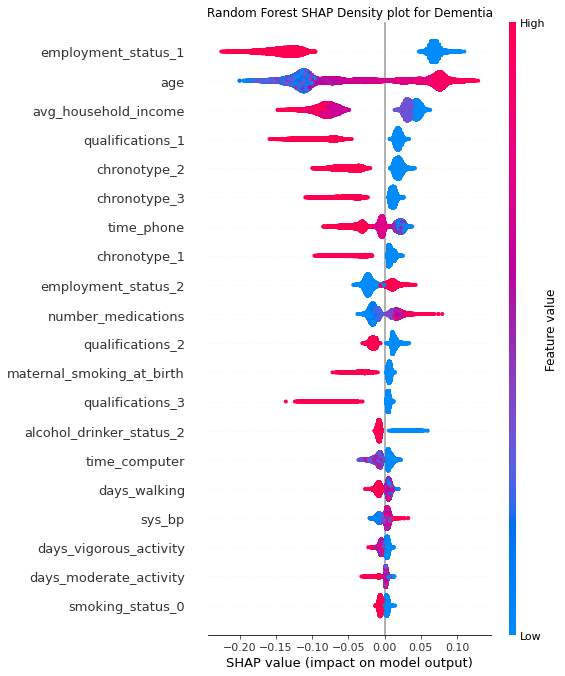

In [48]:
# shap plot
rf_model = grid_search.best_estimator_['rf']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

plt.title('Random Forest SHAP plot for Dementia')
shap.summary_plot(shap_values, features = X_test, class_inds = [1])
plt.show()

plt.title('Random Forest SHAP Density plot for Dementia')
shap.summary_plot(shap_values[1], features = X_test)
plt.show()

# XGBoost 

In [78]:
# train and test split NEW WITH LESS DATA. i didnt do this on RF because that one ran fine and i have no time left

X2 = sampled_data.drop(columns=['incident_case'])
Y2 = sampled_data['incident_case']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X2, Y2, test_size=0.2, random_state=42
)

In [75]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Define the pipeline
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.4)),
    ('under', RandomUnderSampler(sampling_strategy=0.6))
])

# Fit the pipeline to the training data
#pipeline.fit(X_train, y_train)

#rint(f'''Shape of X before SMOTE: {X_train.shape}
#Shape of X after SMOTE: {X_train.shape}''')

#print('\nBalance of positive and negative classes (%):')
#Y_sm.value_counts(normalize=True) * 100

# Check the dimensions of the dataset before and after sampling
print(f"Original dataset shape: {X_train.shape}")
X_resampled, y_resampled = pipeline['over'].fit_resample(X_train, y_train)
X_resampled, y_resampled = pipeline['under'].fit_resample(X_resampled, y_resampled)
print(f"Resampled dataset shape: {X_resampled.shape}")
print(f"Resampled dataset shape, Y: {y_resampled.shape}")

#print('\nBalance of positive and negative classes (%):')
y_resampled.value_counts(normalize=True) * 100

Original dataset shape: (21592, 48)
Resampled dataset shape: (17069, 48)
Resampled dataset shape, Y: (17069,)


0    62.499268
1    37.500732
Name: incident_case, dtype: float64

In [76]:
from xgboost import XGBClassifier
# Define the pipeline
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.4)),
    ('under', RandomUnderSampler(sampling_strategy=0.6)),
    ('xgb', XGBClassifier(seed=42))
])


# Define the parameter grid for grid search
#param_grid = {
 #   'rf__n_estimators': [50, 100, 200],
  #  'rf__max_depth': [2, 5, 10, 15]}

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [5, 10, 15],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__gamma':[i/10.0 for i in range(0,5)]
}


# Define the scoring metric for the grid search
scoring = {'accuracy': 'accuracy', 'recall':'recall', 'F1':'f1'}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring,n_jobs=4, cv=5, return_train_score=True,refit='accuracy')


In [79]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over', SMOTE(sampling_strategy=0.4)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.6)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=N...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=4,
             param_grid={'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'xgb__max_depth': [5, 10, 15],
                         'xgb__min_child_weight': [1, 3, 5, 7],
                         'xgb__n_estimators': [50, 100, 200]},
             refit='accuracy', return_train_score=True,
             scoring={'F1': 'f1', 'accuracy': 'accuracy', 'recall': 'recall'})

In [80]:
# Check the dimensions of the dataset before and after sampling
print(f"Original dataset shape: {X_train.shape}")
X_train_resampled, y_train_resampled = pipeline['over'].fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = pipeline['under'].fit_resample(X_train_resampled, y_train_resampled)
print('Resampled data shape:', X_train_resampled.shape)

Original dataset shape: (21592, 48)
Resampled data shape: (17069, 48)


In [81]:
# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_
print(best_estimator)

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.4)),
                ('under', RandomUnderSampler(sampling_strategy=0.6)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.4, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=7,
                               missing=nan, monotone_

In [82]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'xgb__gamma': 0.4, 'xgb__max_depth': 5, 'xgb__min_child_weight': 7, 'xgb__n_estimators': 50}


In [83]:
# Predict on the test data using the best estimator
y_pred = best_estimator.predict(X_test)

In [84]:
# Accuracy on the test set
from sklearn.metrics import accuracy_score
print("\033[1m Accuracy of XGBoost on test set:","{:.2%}".format(accuracy_score(y_test, y_pred)))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

 Accuracy of XGBoost on test set: 76.53%
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3997
           1       0.54      0.67      0.60      1402

    accuracy                           0.77      5399
   macro avg       0.71      0.73      0.72      5399
weighted avg       0.79      0.77      0.77      5399



In [20]:
# we should use average accuracy not true accuracy
# Access the cv_results_ dictionary
cv_results = grid_search.cv_results_

# Get the mean test accuracy for each parameter combination
mean_test_accuracy = cv_results['mean_test_accuracy']

# Find the index of the best parameter combination
best_index = np.argmax(mean_test_accuracy)

# Get the best mean test accuracy
best_accuracy = mean_test_accuracy[best_index]

# Print the best accuracy
print("Best accuracy:", best_accuracy)

Best accuracy: 0.7699146280087092


In [21]:
# balanced accuracy?
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.7347345387785489

In [22]:
# Calculate metrics on the training data
y_train_pred = best_estimator.predict(X_train_resampled)
accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
print("Train Accuracy:", accuracy_train)

print(classification_report(y_train_resampled, y_train_pred))

Train Accuracy: 0.8179155193625871
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     10668
           1       0.75      0.78      0.76      6401

    accuracy                           0.82     17069
   macro avg       0.81      0.81      0.81     17069
weighted avg       0.82      0.82      0.82     17069



In [23]:
# Calculate the AUC score on the test data
y_prob = best_estimator.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

AUC: 0.8239199192547049


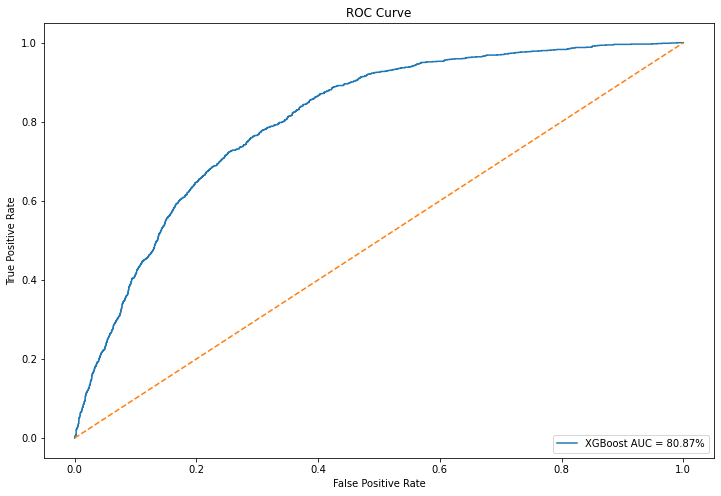

In [86]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
# roc curve
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost AUC = {:.2f}%'.format(auc*100))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.show()

In [87]:
print(tpr_xgb)
print(fpr_xgb)

[0.00000000e+00 7.13266762e-04 2.13980029e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.         0.         0.         ... 0.99874906 0.99974981 1.        ]


Confusion Matrix:
 [[3205  792]
 [ 466  936]]


Text(87.0, 0.5, 'True')

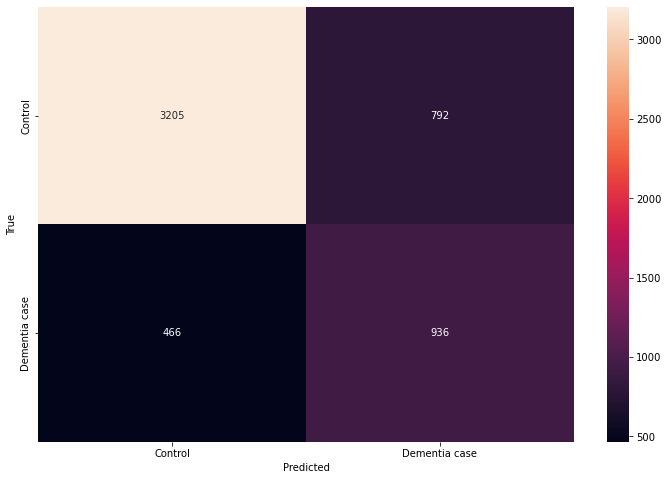

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt='g',
                       xticklabels=['Control', 'Dementia case'],
            yticklabels=['Control', 'Dementia case'])
plt.xlabel('Predicted')
plt.ylabel('True')

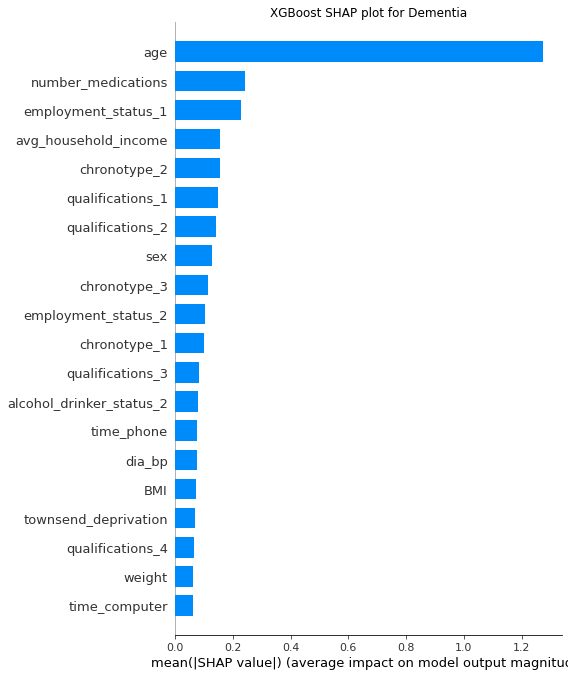

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


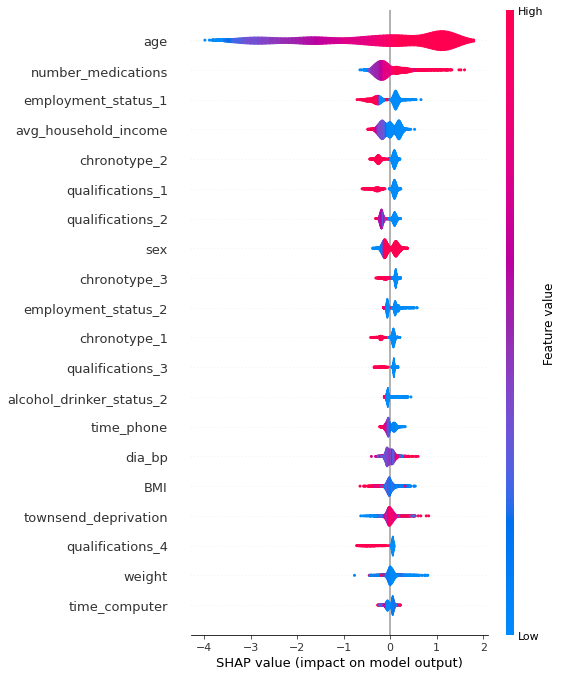

In [34]:
import shap
# shap plot
xgb_model = grid_search.best_estimator_['xgb']
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)

#plt.title('XGBoost SHAP plot for Dementia')
#shap.summary_plot(shap_values, features = X_test, class_inds = [1])
#plt.show()

# Plot the shap summary plot
plt.title('XGBoost SHAP plot for Dementia')
shap.summary_plot(shap_values, X_test, plot_type='bar', class_names=['No Dementia', 'Dementia'])
plt.show()

#plt.title('XGBoost SHAP Density plot for Dementia')
#shap.summary_plot(shap_values[1], features = X_test)
#plt.show()

# Plot the shap dependence plots for each feature
#for i in range(X_test.shape[1]):
 #   plt.title('XGBoost SHAP dependence plot for feature {}'.format(i))
  #  shap.dependence_plot(i, shap_values, X_test)
   # plt.show()

shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "violin")

# SVM

In [90]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Define the pipeline
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=0.4)),
    ('under', RandomUnderSampler(sampling_strategy=0.6)),
    ('standardscaler', StandardScaler()),
    ('svm', SVC())
])

# Define the parameter grid for grid search
# Define the parameter grid for grid search
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svm__gamma': [1,0.1,0.01,0.001]
}

# Define the scoring metric for the grid search
scoring = {'accuracy': 'accuracy', 'recall':'recall', 'F1':'f1'}

# Create the grid search object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring,n_jobs=4, cv=5, return_train_score=True,refit='accuracy')


In [91]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over', SMOTE(sampling_strategy=0.4)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.6)),
                                       ('standardscaler', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=4,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': [1, 0.1, 0.01, 0.001],
                         'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly']},
             refit='accuracy', return_train_score=True,
             scoring={'F1': 'f1', 'accuracy': 'accuracy', 'recall': 'recall'})

In [92]:
# Check the dimensions of the dataset before and after sampling
print(f"Original dataset shape: {X_train.shape}")
X_train_resampled, y_train_resampled = pipeline['over'].fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = pipeline['under'].fit_resample(X_train_resampled, y_train_resampled)
X_train_resampled = pipeline['standardscaler'].fit_transform(X_train_resampled)

print('Resampled data shape:', X_train_resampled.shape)

Original dataset shape: (21592, 48)
Resampled data shape: (17069, 48)


In [93]:
# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_
print(best_estimator)

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.4)),
                ('under', RandomUnderSampler(sampling_strategy=0.6)),
                ('standardscaler', StandardScaler()),
                ('svm', SVC(C=10, gamma=0.1, kernel='linear'))])


In [94]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}


In [95]:
# Predict on the test data using the best estimator
y_pred = best_estimator.predict(X_test)

In [62]:
# Calculate the accuracy score on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Accuracy on the test set
from sklearn.metrics import accuracy_score
print("\033[1m Accuracy of Random forest on test set:","{:.2%}".format(accuracy_score(y_test, y_pred)))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7762548620114836
 Accuracy of Random forest on test set: 77.63%
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3997
           1       0.56      0.67      0.61      1402

    accuracy                           0.78      5399
   macro avg       0.72      0.74      0.73      5399
weighted avg       0.79      0.78      0.78      5399



In [63]:
# we should use average accuracy not true accuracy
# Access the cv_results_ dictionary
cv_results = grid_search.cv_results_

# Get the mean test accuracy for each parameter combination
mean_test_accuracy = cv_results['mean_test_accuracy']

# Find the index of the best parameter combination
best_index = np.argmax(mean_test_accuracy)

# Get the best mean test accuracy
best_accuracy = mean_test_accuracy[best_index]

# Print the best accuracy
print("Best accuracy:", best_accuracy)

Best accuracy: 0.7759814475950542


In [64]:
# Calculate accuracy on the training data
y_train_pred = best_estimator.predict(X_train_resampled)
accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
print("Train Accuracy:", accuracy_train)

print(classification_report(y_train_resampled, y_train_pred))


X does not have valid feature names, but StandardScaler was fitted with feature names


Train Accuracy: 0.4389829515495928
              precision    recall  f1-score   support

           0       0.71      0.17      0.28     10668
           1       0.39      0.88      0.54      6401

    accuracy                           0.44     17069
   macro avg       0.55      0.53      0.41     17069
weighted avg       0.59      0.44      0.38     17069



In [96]:
# Calculate the AUC score on the test data
y_prob = best_estimator.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)

AttributeError: predict_proba is not available when  probability=False

In [100]:
# Calculate the predicted scores on the test data
y_scores = best_estimator.decision_function(X_test)

# Calculate the AUC score on the test data
auc = roc_auc_score(y_test, y_scores)
print("AUC:", auc)


AUC: 0.8360271630256216


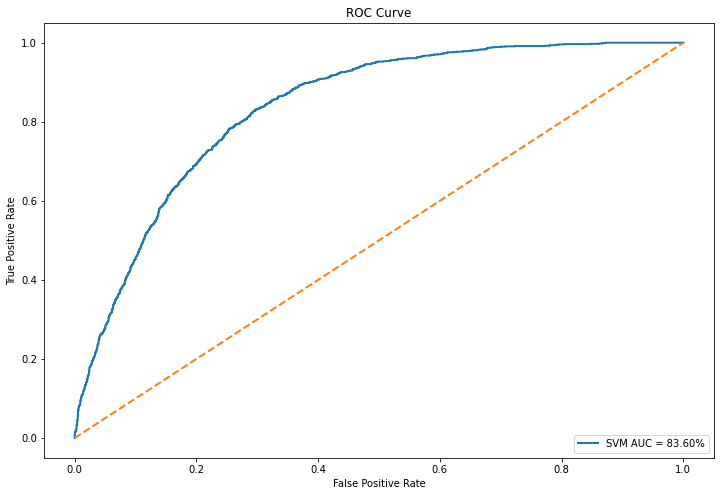

In [101]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the false positive rate and true positive rate
fpr_svm, tpr_svm, thresholds= roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.plot(fpr_svm, tpr_svm, lw=2, label='SVM AUC = {:.2f}%'.format(auc*100))
plt.plot([0, 1], [0, 1],lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix:
 [[3248  749]
 [ 459  943]]


Text(87.0, 0.5, 'True')

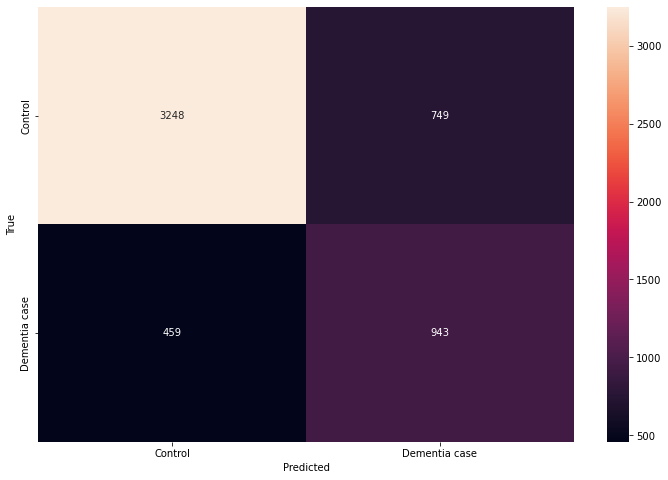

In [70]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt='g',
                       xticklabels=['Control', 'Dementia case'],
            yticklabels=['Control', 'Dementia case'])
plt.xlabel('Predicted')
plt.ylabel('True')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


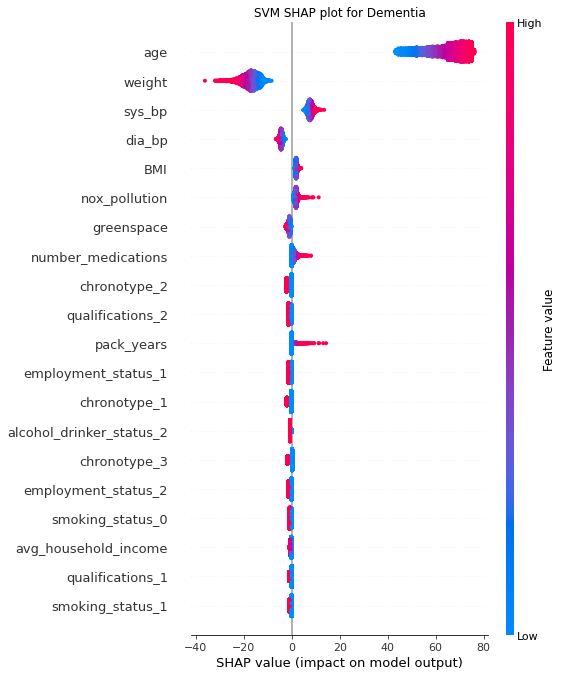

AssertionError: Summary plots need a matrix of shap_values, not a vector.

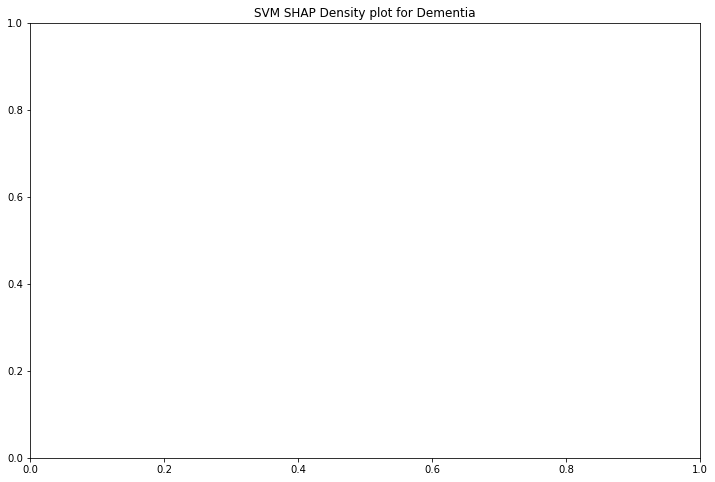

In [73]:
# shap plot
svm_model = grid_search.best_estimator_['svm']
explainer = shap.Explainer(svm_model, X_train_resampled)
shap_values = explainer.shap_values(X_test)

plt.title('SVM SHAP plot for Dementia')
shap.summary_plot(shap_values, features = X_test, class_inds = [1])
plt.show()

plt.title('SVM SHAP Density plot for Dementia')
shap.summary_plot(shap_values[1], features = X_test)
plt.show()

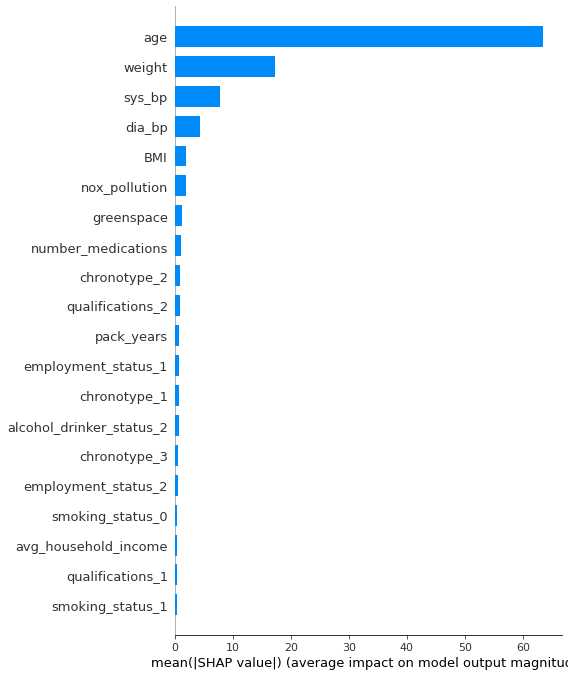

In [76]:

# Generate the summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_train.columns)

# Plot all AUCs together

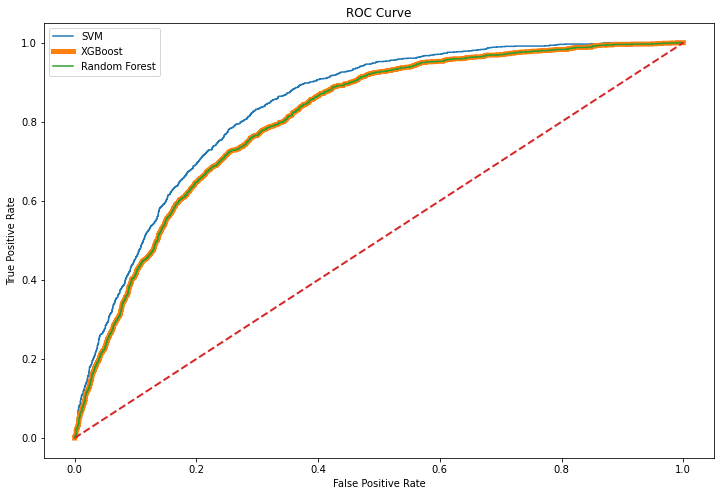

In [106]:
import matplotlib.pyplot as plt

# Plot SVM ROC curve
plt.plot(fpr_svm, tpr_svm, label='SVM')

# Plot XGBoost ROC curve
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost', linewidth=5)

# Plot Random Forest ROC curve
plt.plot(fpr_rf, tpr_rf, label='Random Forest')

# Set axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Add legend
plt.legend()
plt.plot([0, 1], [0, 1],lw=2, linestyle='--')
# Show plot
plt.show()
